# Image Captioning using LSTM on Flickr8K dataset

In [1]:
#importing the libraries
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
from tqdm import tqdm
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.utils import to_categorical
from nltk.translate.bleu_score import sentence_bleu
from numpy import array
import pickle
import numpy as np
import os
import cv2

/shared/centos7/anaconda3/2021.05/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [ ]:
# Download the dataset and unzip it
import requests
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Download function
def download_file(url, filename):
    response = requests.get(url)
    if response.status_code == 200:
        with open(filename, 'wb') as f:
            f.write(response.content)
        print(f"Downloaded {filename}")
    else:
        print(f"Failed to download {filename}")

# Download dataset
dataset_url = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip"
text_url = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip"

download_file(dataset_url, "Flickr8k_Dataset.zip")
download_file(text_url, "Flickr8k_text.zip")

# Extract files
with zipfile.ZipFile("Flickr8k_Dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("Flickr8k_Dataset")
with zipfile.ZipFile("Flickr8k_text.zip", 'r') as zip_ref:
    zip_ref.extractall("Flickr8k_text")

# Load captions
captions_file = "Flickr8k_text/Flickr8k.token.txt"
captions_df = pd.read_csv(captions_file, sep='\t', names=['image', 'caption'])
captions_df['image'] = captions_df['image'].apply(lambda x: x.split('#')[0])

# EDA
print("Total number of captions:", len(captions_df))
print("Number of unique images:", captions_df['image'].nunique())

## Data Visualization and Preprocessing

In [2]:
#converting the text files to pandas dataframe
image_tokens=pd.read_csv("Flickr8k_text/Flickr8k.lemma.token.txt",sep='\t',names=["img_id","img_caption"])
train_image_names=pd.read_csv("Flickr8k_text/Flickr_8k.trainImages.txt",names=["img_id"])
test_image_names=pd.read_csv("Flickr8k_text/Flickr_8k.testImages.txt",names=["img_id"])
val_image_names=pd.read_csv("Flickr8k_text/Flickr_8k.devImages.txt",names=["img_id"])

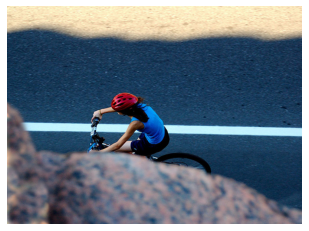

In [3]:
image_path = 'Flickr8k_Dataset/Flicker8k_Dataset/' + train_image_names.img_id[5]
img = cv2.imread(image_path)

# Check if the image was read successfully
if img is not None:
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Hide axes
    plt.show()
else:
    print(f"Error: Unable to read image at path {image_path}")

In [4]:
#removing the #0,#1,#2,#3,#5 from the image ids
image_tokens["img_id"]=image_tokens["img_id"].map(lambda x: x[:len(x)-2])

In [5]:
image_tokens["img_caption"]=image_tokens["img_caption"].map(lambda x: "<start> " + x.strip() + " <end>")

In [6]:
#head of the image_tokens dataframe
image_tokens.head()

,img_id,img_caption
0,1305564994_00513f9a5b.jpg,<start> A man in street racer armor be examine...
1,1305564994_00513f9a5b.jpg,<start> Two racer drive a white bike down a ro...
2,1305564994_00513f9a5b.jpg,<start> Two motorist be ride along on their ve...
3,1305564994_00513f9a5b.jpg,<start> Two person be in a small race car driv...
4,1305564994_00513f9a5b.jpg,<start> Two person in race uniform in a street...


In [7]:
#head of the train_image_names dataframe
train_image_names.head()

,img_id
0,2513260012_03d33305cf.jpg
1,2903617548_d3e38d7f88.jpg
2,3338291921_fe7ae0c8f8.jpg
3,488416045_1c6d903fe0.jpg
4,2644326817_8f45080b87.jpg


### Creating dictionaries to map image_id and their corresponding captions

In [8]:
#creating train dictionary having key as the image id and value as a list of its captions
train_captions={}
for i in tqdm(range(len(train_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_id"]==train_image_names["img_id"].iloc[i]].img_caption)]
  train_captions[train_image_names["img_id"].iloc[i]]=l

100%|██████████| 6000/6000 [00:14<00:00, 402.01it/s]


In [9]:
#creating test dictionary having key as the image id and value as a list of its captions
test_captions={}
for i in tqdm(range(len(test_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_id"]==test_image_names["img_id"].iloc[i]].img_caption)]
  test_captions[test_image_names["img_id"].iloc[i]]=l

100%|██████████| 1000/1000 [00:02<00:00, 404.68it/s]


In [10]:
#creating validation dictionary having key as the image id and value as a list of its captions
validation_captions={}
for i in tqdm(range(len(val_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_id"]==val_image_names["img_id"].iloc[i]].img_caption)]
  validation_captions[val_image_names["img_id"].iloc[i]]=l

100%|██████████| 1000/1000 [00:02<00:00, 393.16it/s]


### ResNet50 model for encoding images

In [ ]:
model=ResNet50(include_top=False, weights='imagenet',pooling='avg',input_shape=(224,224,3))
model.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

### Encoding images and forming dictionaries containing mapping of image_id to image encodings

In [ ]:
import tensorflow as tf
# Suppress TensorFlow logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tqdm import tqdm
import numpy as np

path = "Flickr8k_Dataset/Flicker8k_Dataset/"
train_features = {}

# Use tqdm for progress bar
for image_name in tqdm(train_captions, desc='Extracting features', ncols=100):
    img_path = path + image_name
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    # Predict features
    features = model.predict(x, verbose=0)
    
    train_features[image_name] = features.squeeze()

print("\nFeature extraction completed.")

100%|██████████| 6000/6000 [06:33<00:00, 15.24it/s]


In [ ]:
with open( "train_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(train_features, pickle_f )

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tqdm import tqdm
import numpy as np

# Suppress TensorFlow logging
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

path = "Flickr8k_Dataset/Flicker8k_Dataset/"
test_features = {}

# Use tqdm for progress bar
for image_name in tqdm(test_captions, desc='Extracting features', ncols=100):
    img_path = path + image_name
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    # Predict features with verbose=0 to suppress output
    features = model.predict(x, verbose=0)
    
    test_features[image_name] = features.squeeze()

print("\nFeature extraction completed.")

100%|██████████| 1000/1000 [01:05<00:00, 15.17it/s]


In [ ]:
with open( "test_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(test_features, pickle_f )

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tqdm import tqdm
import numpy as np

# Suppress TensorFlow logging
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

path = "Flickr8k_Dataset/Flicker8k_Dataset/"
validation_features = {}

# Use tqdm for progress bar
for image_name in tqdm(validation_captions, desc='Extracting validation features', ncols=100):
    img_path = path + image_name
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    # Predict features with verbose=0 to suppress output
    features = model.predict(x, verbose=0)
    
    validation_features[image_name] = features.squeeze()

print("\nValidation feature extraction completed.")

100%|██████████| 1000/1000 [01:05<00:00, 15.19it/s]


In [ ]:
with open( "validation_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(validation_features, pickle_f )

### Setting hyper parameters for vocabulary size and maximum length

In [11]:
all_captions=[]
for img_id in tqdm(train_captions):
  for captions in train_captions[img_id]:
    all_captions.append(captions)

all_words=" ".join(all_captions)
print()
print(len(all_words))
unique_words=list(set(all_words.strip().split(" ")))
print(len(unique_words))

100%|██████████| 6000/6000 [00:00<00:00, 396643.25it/s]


1991192
6328


In [12]:
#defining max_length and vocabulary size
vocab_size=len(unique_words)+1
max_length=40

### Creating dictionaries containg mapping of words to indices and indices to words

In [ ]:
#forming dictionaries containg mapping of words to indices and indices to words
words_to_indices={val:index+1 for index, val in enumerate(unique_words)}
indices_to_words = { index+1:val for index, val in enumerate(unique_words)}
words_to_indices["Unk"]=0
indices_to_words[0]="Unk"

### Transforming data into dictonary mapping of image_id to encoded captions

In [ ]:
#forming dictionary having encoded captions
train_encoded_captions={}
for img_id in tqdm(train_captions):
  train_encoded_captions[img_id]=[]
  for i in range(5):
    train_encoded_captions[img_id].append([words_to_indices[s] for s in train_captions[img_id][i].split(" ")])

100%|██████████| 6000/6000 [00:00<00:00, 48349.23it/s]


In [ ]:
for img_id in tqdm(train_encoded_captions):
  train_encoded_captions[img_id]=pad_sequences(train_encoded_captions[img_id], maxlen=max_length, padding='post')

100%|██████████| 6000/6000 [00:00<00:00, 24903.02it/s]


In [ ]:
for x in train_encoded_captions['2513260012_03d33305cf.jpg'][2]:
  print(indices_to_words[x])

<start>
Two
dog
chase
each
other
across
the
snowy
ground
.
<end>
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk


## Data Generator

In [ ]:
def data_generator(train_encoded_captions, train_features, num_of_photos):
    X1, X2, Y = list(), list(), list()
    max_length = 40
    n = 0
    for img_id in tqdm(train_encoded_captions):
        n += 1
        for i in range(5):
            for j in range(1, 40):
                curr_sequence = train_encoded_captions[img_id][i][0:j].tolist()
                next_word = train_encoded_captions[img_id][i][j]
                curr_sequence = pad_sequences([curr_sequence], maxlen=max_length, padding='post')[0]
                one_hot_next_word = to_categorical([next_word], vocab_size)[0]
                X1.append(train_features[img_id])
                X2.append(curr_sequence)
                Y.append(one_hot_next_word)
        if n == num_of_photos:
            yield (np.array(X1), np.array(X2)), np.array(Y)
            X1, X2, Y = list(), list(), list()
            n = 0

## Modelling

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, add, Embedding

In [ ]:
for i in train_features:
  print(train_features[i].shape)
  break

(2048,)


## Model

In [13]:
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add, Concatenate, Attention, AdditiveAttention
from tensorflow.keras.models import Model

max_length = 40

# Image feature input
input_1 = Input(shape=(2048,))
dropout_1 = Dropout(0.2)(input_1)
dense_1 = Dense(256, activation='relu')(dropout_1)

# Text input
input_2 = Input(shape=(max_length,))
embedding_1 = Embedding(vocab_size, 256)(input_2)
dropout_2 = Dropout(0.2)(embedding_1)

# LSTM layer
lstm_1 = LSTM(256, return_sequences=True)(dropout_2)

# Attention mechanism
attention = AdditiveAttention()([lstm_1, dense_1])

# Combine attention output with LSTM output
context_vector = Concatenate()([attention, lstm_1])

# Final LSTM layer
lstm_2 = LSTM(256)(context_vector)

# Combine image features and text features
add_1 = add([dense_1, lstm_2])

# Output layers
dense_2 = Dense(256, activation='relu')(add_1)
dense_3 = Dense(vocab_size, activation='softmax')(dense_2)

# Create the model
model = Model(inputs=[input_1, input_2], outputs=dense_3)

# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 40)]                 0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 40, 256)              1620224   ['input_2[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 2048)                 0         ['input_1[0][0]']             
                                                                                              

In [14]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])


In [ ]:
len(train_encoded_captions)

6000

## Training

In [ ]:
import tensorflow as tf

def generator_wrapper():
    return data_generator(train_encoded_captions, train_features, no_of_photos)

output_signature = (
    (tf.TensorSpec(shape=(None, 2048), dtype=tf.float32),
     tf.TensorSpec(shape=(None, max_length), dtype=tf.int32)),
    tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32)
)

dataset = tf.data.Dataset.from_generator(
    generator_wrapper,
    output_signature=output_signature
)

epochs = 1
no_of_photos = 2
steps = len(train_encoded_captions) // no_of_photos

model.fit(dataset, epochs=epochs, steps_per_epoch=steps, verbose=1)

In [ ]:
epochs=5
no_of_photos=5
steps=len(train_encoded_captions)//no_of_photos
for i in range(epochs):
  generator=data_generator(train_encoded_captions,train_features,no_of_photos)
  model.fit(generator,epochs=1,steps_per_epoch=steps,verbose=1)

In [ ]:
test_features

# Greedy Search function

In [ ]:
def greedy_search(photo):
  photo=photo.reshape(1,2048)
  in_text='<start>'
  for i in range(max_length):
    sequence = [words_to_indices[s] for s in in_text.split(" ") if s in words_to_indices]
    sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
    y_pred = model.predict([photo,sequence],verbose=0)
    y_pred = np.argmax(y_pred[0])
    word = indices_to_words[y_pred]
    in_text += ' ' + word
    if word == '<end>':
      break
  final = in_text.split()
  final = final[1:-1]
  #final = " ".join(final)
  return final

## Predicting Captions on Test Set using Greedy Search

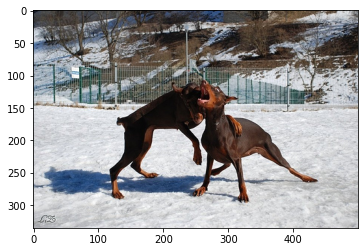

Referance Captions: 
Dog be in the snow in front of a fence .
Dog play on the snow .
Two brown dog playful fight in the snow .
Two brown dog wrestle in the snow .
Two dog play in the snow .
Predicted Caption: 
A doberman be run through the grass .
bleu score:  0.7825422900366437


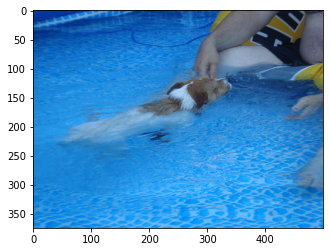

Referance Captions: 
a brown and white dog swim towards some in a pool
A dog in a swim pool swim toward sombody we cannot see .
A dog swim in a pool near a person .
Small dog be paddle through the water in a pool .
A small brown and white dog be in a pool .
Predicted Caption: 
A boy be jump into a pool .
bleu score:  0.32347562464306545


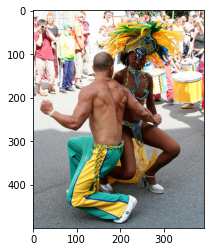

Referance Captions: 
A man and a woman in festive costume dance .
A man and a woman with feather on her head dance .
A man and a woman wear decorative costume and dance in a crowd of onlooker .
one performer wear a feathered headdress dance with another performer in street
Two person be dance with drum on the right and a crowd behind them .
Predicted Caption: 
A man in a red shirt be sit on a street .
bleu score:  0.6076795808137692


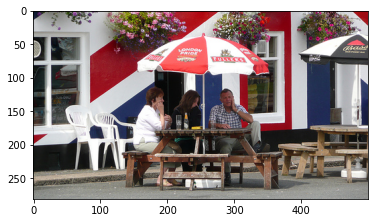

Referance Captions: 
A couple of person sit outdoors at a table with an umbrella and talk .
Three person be sit at an outside picnic bench with an umbrella .
Three person sit at an outdoor cafe .
Three person sit at an outdoor table in front of a building paint like the Union Jack .
Three person sit at a picnic table outside of a building paint like a union jack .
Predicted Caption: 
A man in a white shirt be jump in a park .
bleu score:  0.7736620501360001


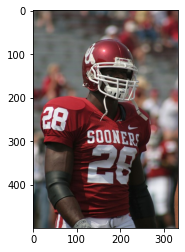

Referance Captions: 
A man be wear a Sooner red football shirt and helmet .
A Oklahoma Sooner football player wear his jersey number 28 .
A Sooner football player weas the number 28 and black armband .
Guy in red and white football uniform
The American footballer be wear a red and white strip .
Predicted Caption: 
A football player in a red helmet .
bleu score:  0.8091067115702212


In [ ]:
i=0
for img_id in test_features:
  i+=1
  img=cv2.imread("all_images/Flicker8k_Dataset"+ "/" + img_id)
  plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  photo=test_features[img_id]
  plt.show()
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=greedy_search(photo)
  score = sentence_bleu(reference, candidate)
  print("Referance Captions: ")
  for cap in reference:
    print(" ".join(cap))
  print("Predicted Caption: ")
  print(" ".join(candidate))
  print("bleu score: ",score)
  if(i==5):
    break

## Calculating Average Bleu Score on Test Set using Greedy Search

In [ ]:
i=0
tot_score=0
for img_id in tqdm(test_features):
  i+=1
  photo=test_features[img_id]
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=greedy_search(photo)
  score = sentence_bleu(reference, candidate)
  tot_score+=score
avg_score=tot_score/i
print()
print("Bleu score on Greedy search")
print("Score: ",avg_score)

100%|██████████| 1000/1000 [13:34<00:00,  1.23it/s]


Bleu score on Greedy search
Score:  0.4776410409015063


## Computing Semantic Similarity with LLM

### Prompt Given to chatgpt

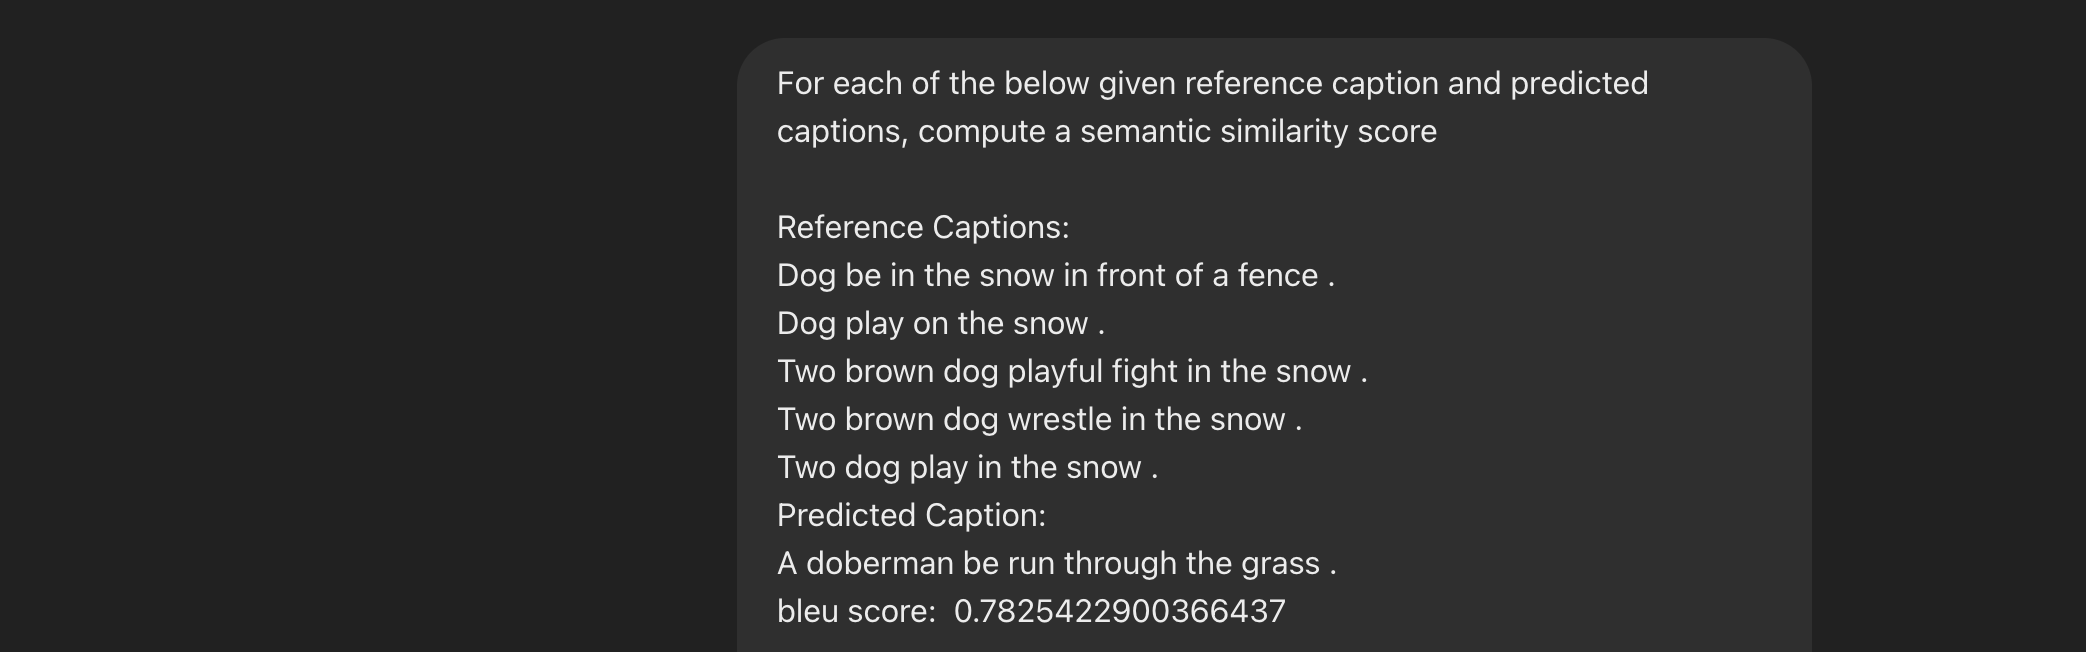

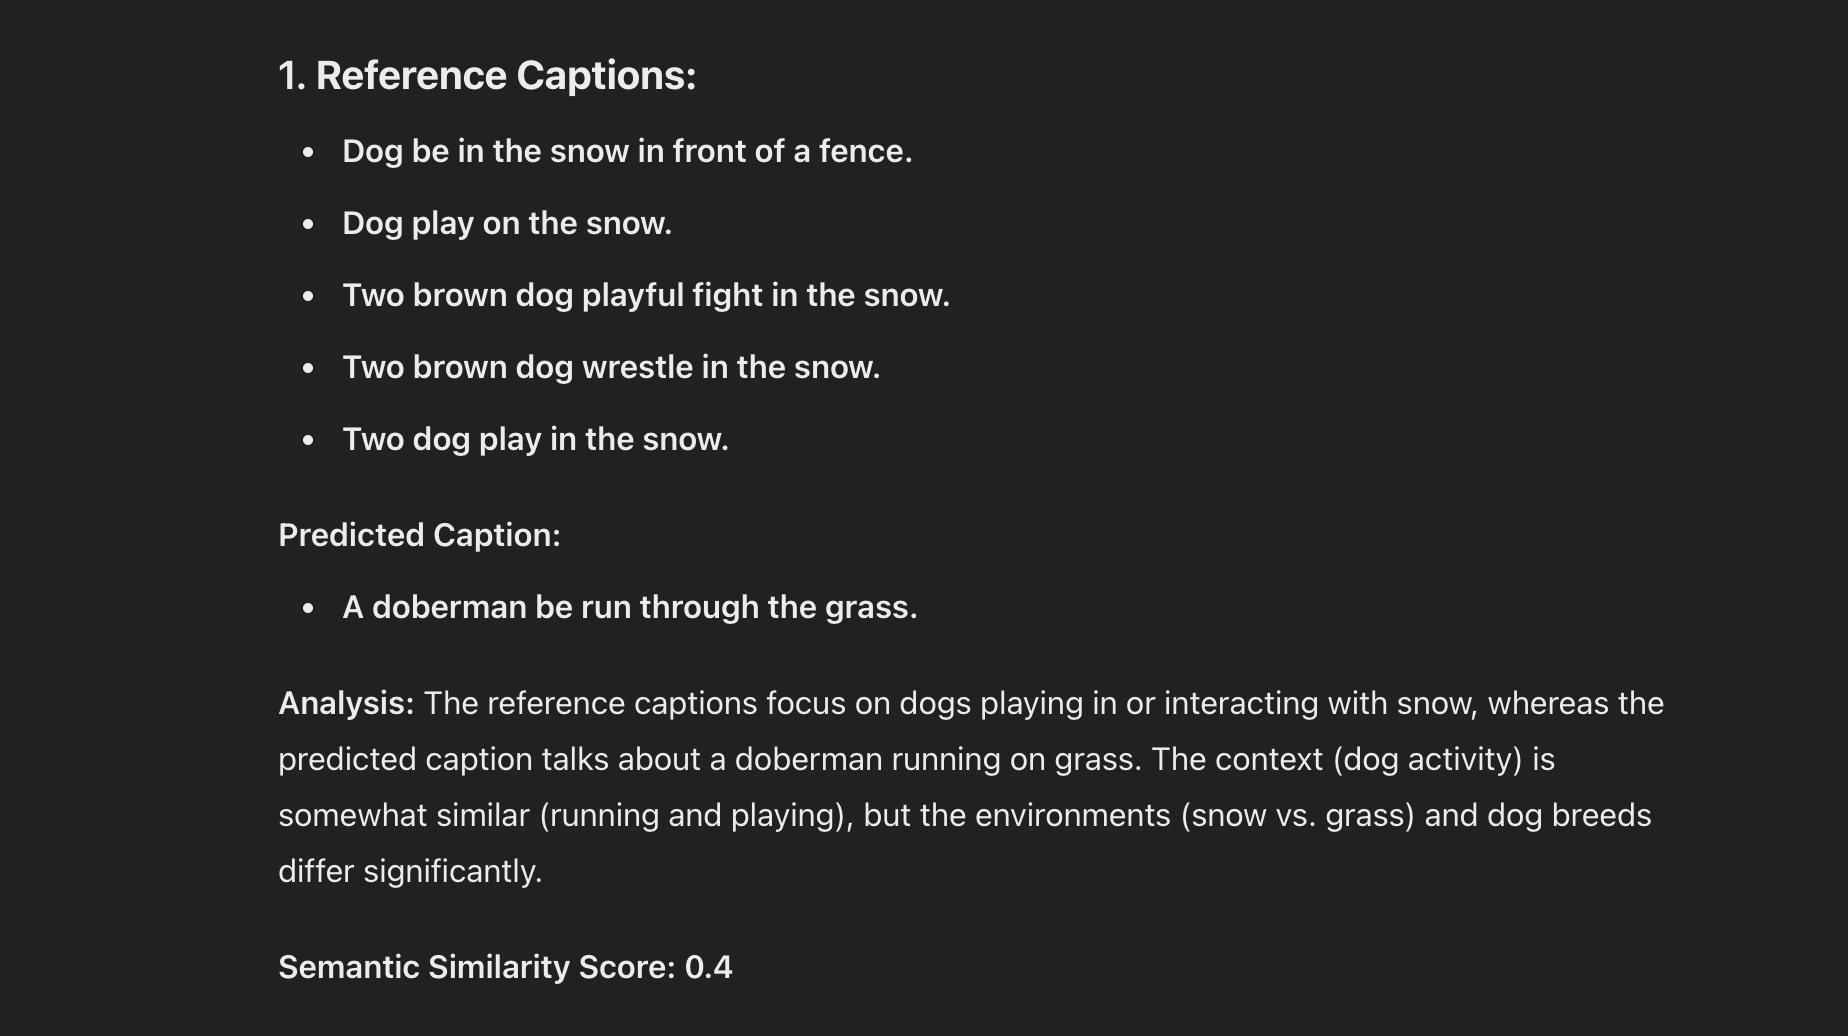

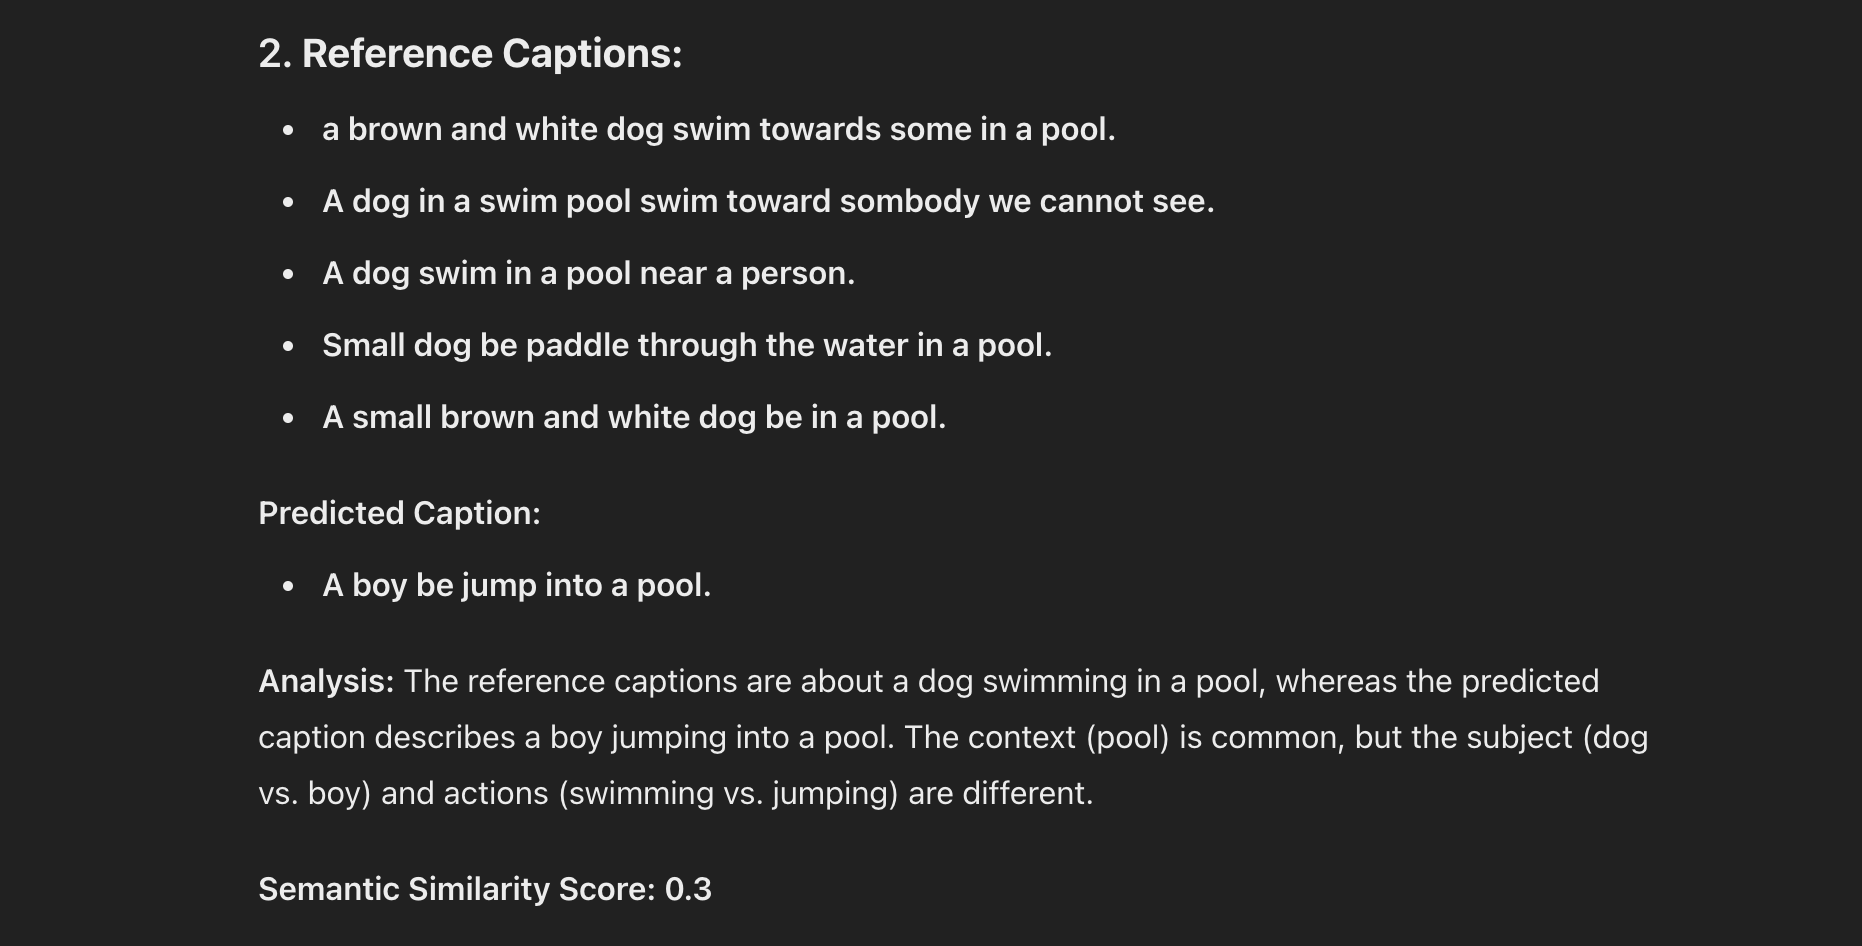

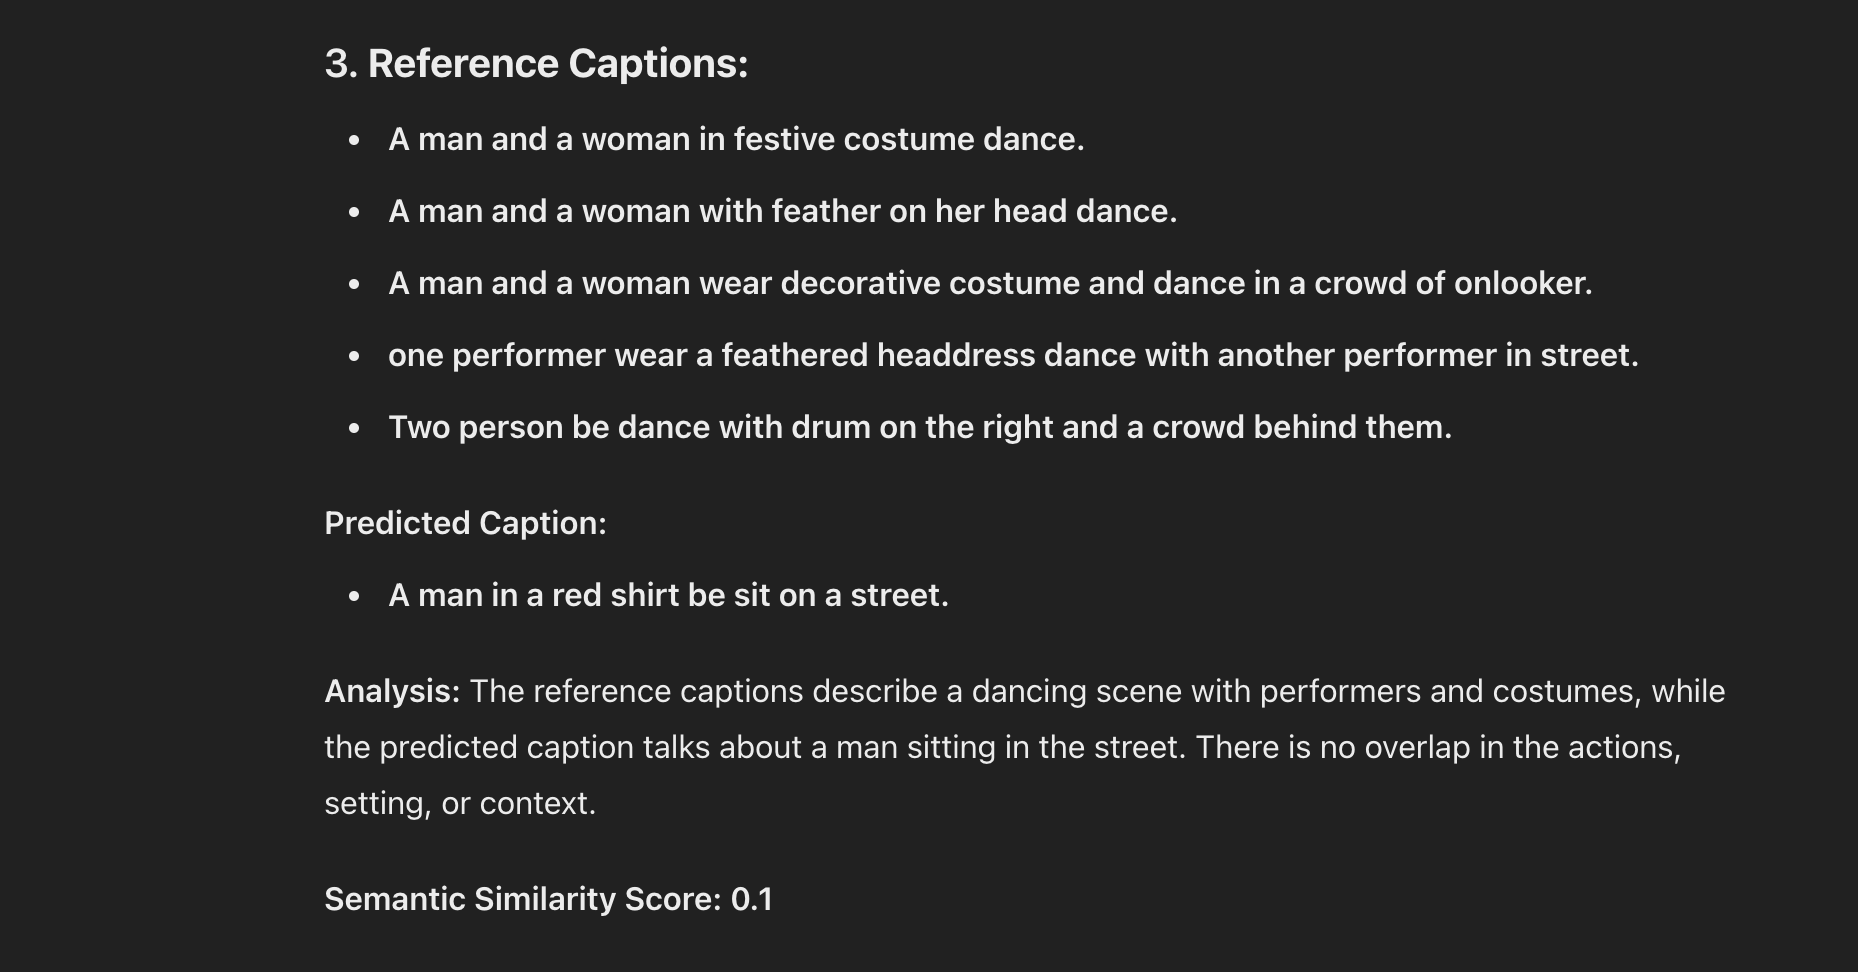

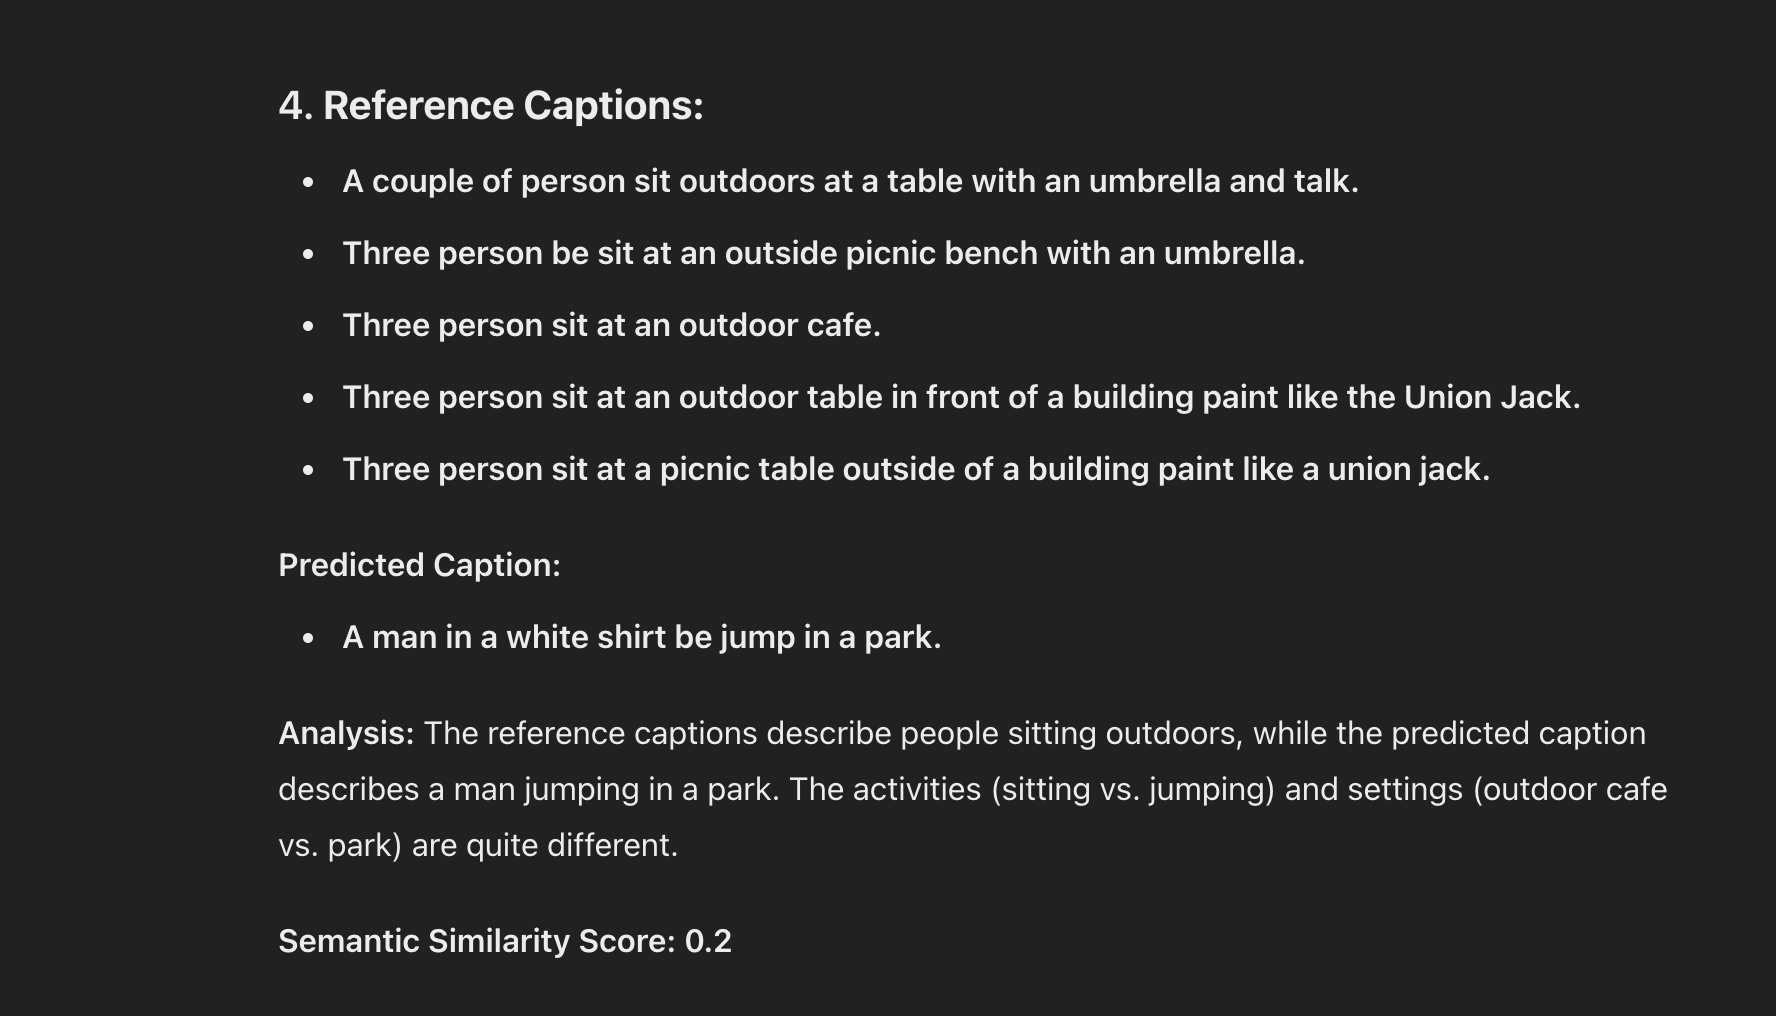

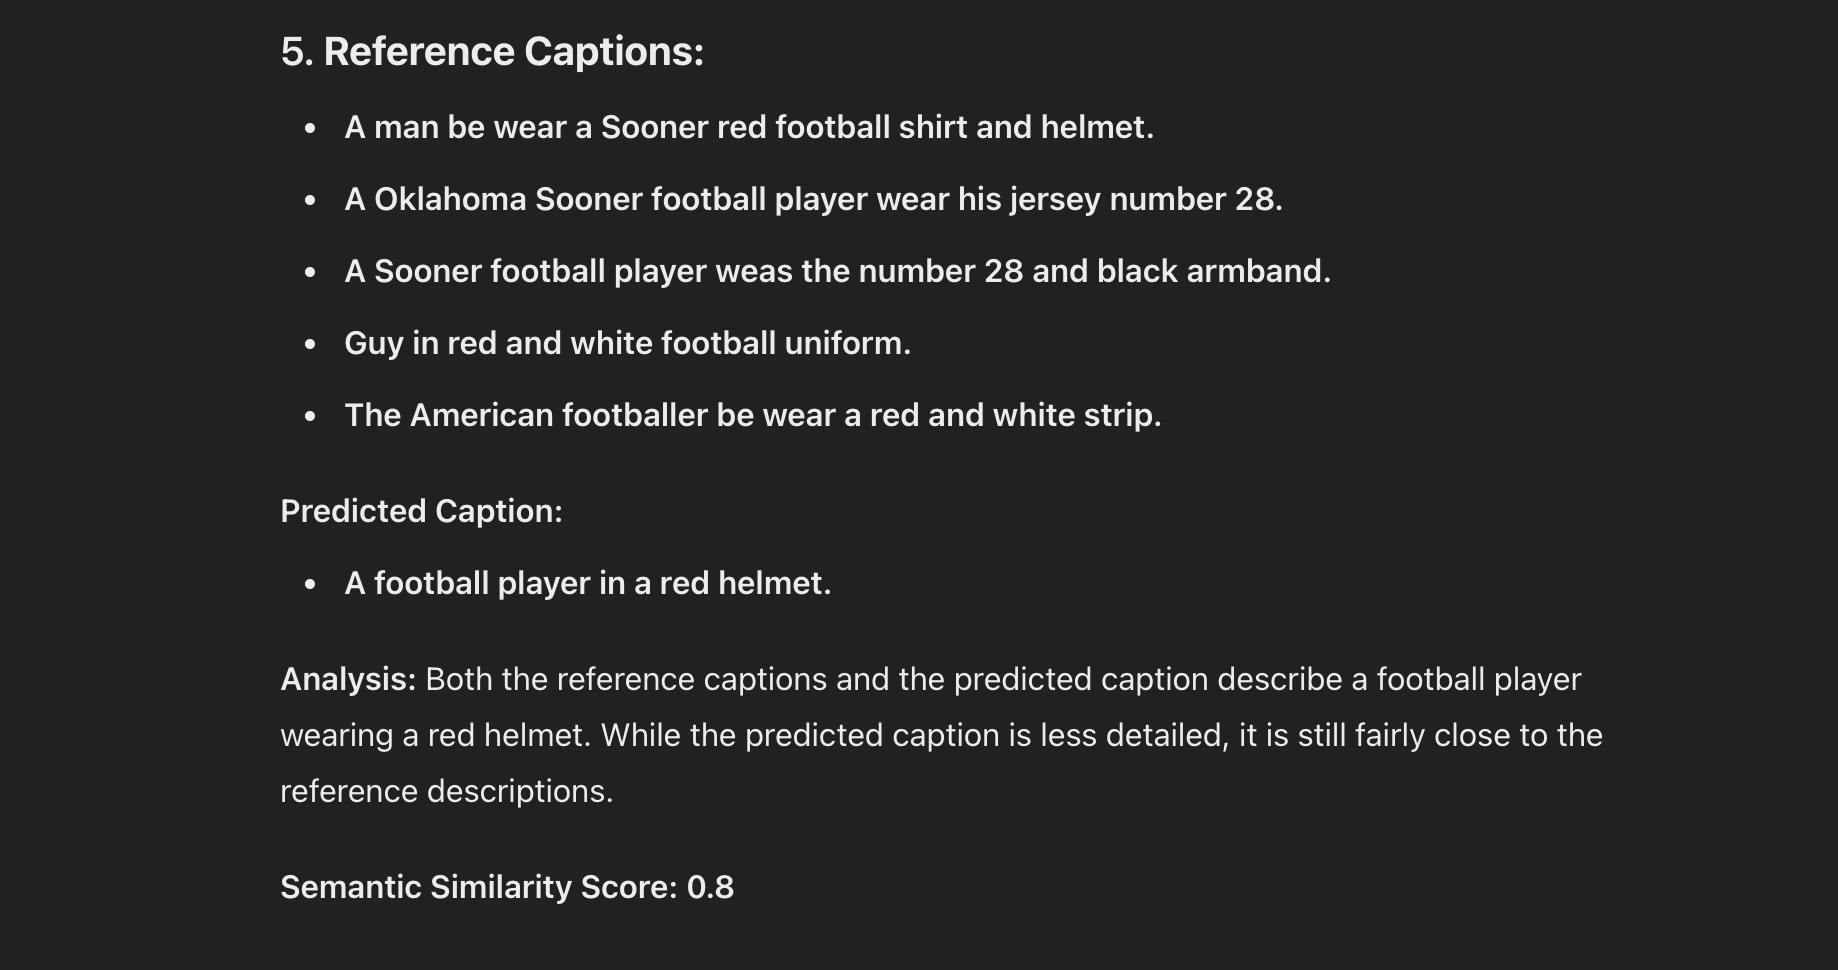